Box([-1.2  -0.07], [0.6  0.07], (2,), float32)
Discrete(3)


c:\Python39\lib\site-packages\keras\optimizers\optimizer_v2\adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


1/1 [==============================] - 0s 18ms/step
episode: 0/60, score: 25.067108221876673
1/1 [==============================] - 0s 20ms/step
episode: 1/60, score: 0
1/1 [==============================] - 0s 15ms/step
episode: 2/60, score: 28.320115488488522
1/1 [==============================] - 0s 23ms/step
episode: 3/60, score: 28.77055760149341
1/1 [==============================] - 0s 20ms/step
episode: 4/60, score: 3.2934473394754527
1/1 [==============================] - 0s 19ms/step
episode: 5/60, score: 3.6788045126993243
1/1 [==============================] - 0s 19ms/step
episode: 6/60, score: 5.381795193171973
1/1 [==============================] - 0s 24ms/step
episode: 7/60, score: 0
1/1 [==============================] - 0s 24ms/step
episode: 8/60, score: 0
1/1 [==============================] - 0s 46ms/step
episode: 9/60, score: 3.3211357862024125
1/1 [==============================] - 0s 29ms/step
episode: 10/60, score: 10.769107620508695
1/1 [========================

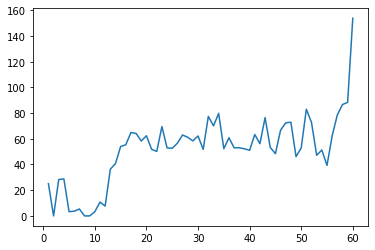

: 

In [1]:
#CAR TRY

import gym
import random
from keras import Sequential
from collections import deque
from keras.layers import Dense
from keras.optimizers import Adam
import matplotlib.pyplot as plt
from keras.activations import relu, linear

import numpy as np
env = gym.make('MountainCar-v0')
env.seed(110)
np.random.seed(10)


class DQN:

    """ Implementation of deep q learning algorithm """

    def __init__(self, action_space, state_space):

        self.action_space = action_space
        self.state_space = state_space
        self.epsilon = 1.0
        self.gamma = .95
        self.batch_size = 64
        self.epsilon_min = .01
        self.lr = 0.001
        self.epsilon_decay = .995
        self.memory = deque(maxlen=100000)
        self.model = self.build_model()

    def build_model(self):

        model = Sequential()
        model.add(Dense(20, input_dim=self.state_space, activation=relu))
        model.add(Dense(25, activation=relu))
        model.add(Dense(self.action_space, activation=linear))
        model.compile(loss='mse', optimizer=Adam(lr=self.lr))
        return model

    def remember(self, state, action, reward, next_state, done):
        self.memory.append((state, action, reward, next_state, done))

    def act(self, state):

        if np.random.rand() <= self.epsilon:
            return random.randrange(self.action_space)
        act_values = self.model.predict(state)
        return np.argmax(act_values[0])

    def replay(self):

        if len(self.memory) < self.batch_size:
            return

        minibatch = random.sample(self.memory, self.batch_size)
        states = np.array([i[0] for i in minibatch])
        actions = np.array([i[1] for i in minibatch])
        rewards = np.array([i[2] for i in minibatch])
        next_states = np.array([i[3] for i in minibatch])
        dones = np.array([i[4] for i in minibatch])

        states = np.squeeze(states)
        next_states = np.squeeze(next_states)

        targets = rewards + self.gamma*(np.amax(self.model.predict_on_batch(next_states), axis=1))*(1-dones)
        targets_full = self.model.predict_on_batch(states)

        ind = np.array([i for i in range(self.batch_size)])
        targets_full[[ind], [actions]] = targets

        self.model.fit(states, targets_full, epochs=1, verbose=0)
        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay


def get_reward(state):

    if state[0] >= 0.5:
        print("Car has reached the goal")
        return 10
    if state[0] > -0.4:
        return (1+state[0])**2
    return 0


def train_dqn(episode):

    loss = []
    agent = DQN(env.action_space.n, env.observation_space.shape[0])
    for e in range(episode):
        state = env.reset()
        state = np.reshape(state, (1, 2))
        score = 0
        max_steps = 1000
        for i in range(max_steps):
            action = agent.act(state)
            env.render()
            next_state, reward, done, _ = env.step(action)
            reward = get_reward(next_state)
            score += reward
            next_state = np.reshape(next_state, (1, 2))
            agent.remember(state, action, reward, next_state, done)
            state = next_state
            agent.replay()
            if done:
                print("episode: {}/{}, score: {}".format(e, episode, score))
                break
        loss.append(score)
    return loss


def random_policy(episode, step):

    for i_episode in range(episode):
        env.reset()
        for t in range(step):
            env.render()
            action = env.action_space.sample()
            state, reward, done, info = env.step(action)
            if done:
                print("Episode finished after {} timesteps".format(t+1))
                break
            print("Starting next episode")


if __name__ == '__main__':

    print(env.observation_space)
    print(env.action_space)
    episodes = 60
    loss = train_dqn(episodes)
    plt.plot([i+1 for i in range(episodes)], loss)
    plt.show()